In [317]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
import math
from utils import *
import seaborn as sns
from scipy import stats

In [318]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [319]:
edau = EDAUtils()
statsu = StatsUtils()

In [320]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [321]:
k = 9
eps = 1.5 
n_rows = 100
# Load labeled data
labeled_scenarios_df = pd.read_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{n_rows}_k{k}_eps{eps}.csv'))
labeled_scenarios_df

Resources   Economy   Bureaucracy  Pollution   time  run_id  \
0        1.000000  0.100000  1.000000e-02   0.001000    0.0     1.0   
1        0.999951  0.100172  1.004647e-02   0.001101    0.2     1.0   
2        0.999901  0.100345  1.009319e-02   0.001203    0.4     1.0   
3        0.999849  0.100519  1.014014e-02   0.001304    0.6     1.0   
4        0.999796  0.100694  1.018734e-02   0.001406    0.8     1.0   
...           ...       ...           ...        ...    ...     ...   
100095   0.000209  0.020162  9.452395e-07   1.143534  199.2   100.0   
100096   0.000209  0.020162  9.224389e-07   1.143534  199.4   100.0   
100097   0.000209  0.020162  9.001884e-07   1.143534  199.6   100.0   
100098   0.000209  0.020162  8.784745e-07   1.143534  199.8   100.0   
100099   0.000209  0.020162  8.572844e-07   1.143534  200.0   100.0   

        kmeans_cluster_id  dbscan_cluster_id  
0                       0                 -1  
1                       0                 -1  
2                       0                 -1  
3                       0                 -1  
4                       0                 -1  
...                   ...                ...  
100095                  1                 -1  
100096                  1                 -1  
100097                  1                 -1  
100098                  1                 -1  
100099                  1                 -1  

[100100 rows x 8 columns]

In [322]:
# Create a test subset of the data
test_df = labeled_scenarios_df[labeled_scenarios_df['run_id'] < 6].copy()
test_df

Resources   Economy   Bureaucracy  Pollution   time  run_id  \
0      1.000000  0.100000  1.000000e-02   0.001000    0.0     1.0   
1      0.999951  0.100172  1.004647e-02   0.001101    0.2     1.0   
2      0.999901  0.100345  1.009319e-02   0.001203    0.4     1.0   
3      0.999849  0.100519  1.014014e-02   0.001304    0.6     1.0   
4      0.999796  0.100694  1.018734e-02   0.001406    0.8     1.0   
...         ...       ...           ...        ...    ...     ...   
5000   0.000137  0.327149  3.270879e-07   0.870234  199.2     5.0   
5001   0.000137  0.327148  3.172010e-07   0.870234  199.4     5.0   
5002   0.000137  0.327148  3.076130e-07   0.870235  199.6     5.0   
5003   0.000137  0.327147  2.983148e-07   0.870235  199.8     5.0   
5004   0.000137  0.327147  2.892977e-07   0.870236  200.0     5.0   

      kmeans_cluster_id  dbscan_cluster_id  
0                     0                 -1  
1                     0                 -1  
2                     0                 -1  
3                     0                 -1  
4                     0                 -1  
...                 ...                ...  
5000                  8                 -1  
5001                  8                 -1  
5002                  8                 -1  
5003                  8                 -1  
5004                  8                 -1  

[5005 rows x 8 columns]

## Label Experimental Design and EDA

In [323]:
# Load exp_design data
exp_design_df = pd.read_csv(os.path.join(tableu_dir, f'exp_design_python_ver_{n_rows}.csv'))
exp_design_df.head()

k_resources:X  ef_economy_resources_on_prod:X  ef_bureaucracy_on_prod:X  \
0       1.129034                        0.802748                  0.951673   
1       0.607121                        1.378729                  0.851854   
2       0.991201                        0.790979                  1.021124   
3       0.773981                        1.488040                  0.663542   
4       1.111947                        1.203423                  1.449691   

   k_deprec:X  ef_pollution_on_depreciation:X  k_bureaucracy:X  \
0    0.771246                        1.054154         1.150654   
1    1.340985                        1.165829         0.576498   
2    0.933654                        1.324236         1.435745   
3    1.373196                        0.943706         0.886828   
4    0.995553                        0.898652         0.605292   

   ef_economy_on_bureaucracy:X  k_decay_bureaucracy:X  \
0                     1.047367               1.404866   
1                     0.797978               0.681097   
2                     0.988815               0.885192   
3                     0.528715               1.390652   
4                     0.632564               1.147411   

   ef_pollution_on_bureaucracy:X  k_pollution:X  k_pollution_decay:X  run_id  
0                       1.017729       0.523315             1.092041       1  
1                       1.102719       1.238542             0.707632       2  
2                       0.901653       1.116684             0.890304       3  
3                       0.706519       1.182834             0.562873       4  
4                       1.321983       0.705844             1.409353       5

In [324]:
# Create a df that has the unique run ids and the corresponding cluster id
runs_cluster_mapping = labeled_scenarios_df.groupby('run_id')[['kmeans_cluster_id', 'dbscan_cluster_id']].first().reset_index()
runs_cluster_mapping

run_id  kmeans_cluster_id  dbscan_cluster_id
0      1.0                  0                 -1
1      2.0                  0                 -1
2      3.0                  0                 -1
3      4.0                  2                 -1
4      5.0                  8                 -1
..     ...                ...                ...
95    96.0                  1                 -1
96    97.0                  0                 -1
97    98.0                  8                 -1
98    99.0                  1                 -1
99   100.0                  1                 -1

[100 rows x 3 columns]

In [325]:
# Merge the exp_design_df with the runs_cluster_mapping to get the cluster ids for each run
exp_design_df = pd.merge(exp_design_df, runs_cluster_mapping, on='run_id', how='left')
exp_design_df

k_resources:X  ef_economy_resources_on_prod:X  ef_bureaucracy_on_prod:X  \
0        1.129034                        0.802748                  0.951673   
1        0.607121                        1.378729                  0.851854   
2        0.991201                        0.790979                  1.021124   
3        0.773981                        1.488040                  0.663542   
4        1.111947                        1.203423                  1.449691   
..            ...                             ...                       ...   
95       0.501028                        1.126169                  0.604027   
96       0.648609                        0.769482                  0.867676   
97       1.011471                        1.165620                  0.922474   
98       0.700959                        1.279449                  1.259462   
99       0.916659                        1.319547                  1.472568   

    k_deprec:X  ef_pollution_on_depreciation:X  k_bureaucracy:X  \
0     0.771246                        1.054154         1.150654   
1     1.340985                        1.165829         0.576498   
2     0.933654                        1.324236         1.435745   
3     1.373196                        0.943706         0.886828   
4     0.995553                        0.898652         0.605292   
..         ...                             ...              ...   
95    0.819966                        0.790037         1.091707   
96    1.006221                        0.778869         0.872433   
97    0.701815                        1.425842         0.840765   
98    1.106405                        0.628175         0.933069   
99    1.427246                        1.483032         0.660673   

    ef_economy_on_bureaucracy:X  k_decay_bureaucracy:X  \
0                      1.047367               1.404866   
1                      0.797978               0.681097   
2                      0.988815               0.885192   
3                      0.528715               1.390652   
4                      0.632564               1.147411   
..                          ...                    ...   
95                     0.992967               0.890346   
96                     1.447145               1.078563   
97                     0.557714               0.646928   
98                     0.864579               1.063687   
99                     0.956161               0.552365   

    ef_pollution_on_bureaucracy:X  k_pollution:X  k_pollution_decay:X  run_id  \
0                        1.017729       0.523315             1.092041       1   
1                        1.102719       1.238542             0.707632       2   
2                        0.901653       1.116684             0.890304       3   
3                        0.706519       1.182834             0.562873       4   
4                        1.321983       0.705844             1.409353       5   
..                            ...            ...                  ...     ...   
95                       0.847967       0.945864             0.761368      96   
96                       0.546437       1.191723             1.496639      97   
97                       1.381270       0.594229             0.900037      98   
98                       0.952962       0.631346             0.664989      99   
99                       1.394836       1.387592             1.359374     100   

    kmeans_cluster_id  dbscan_cluster_id  
0                   0                 -1  
1                   0                 -1  
2                   0                 -1  
3                   2                 -1  
4                   8                 -1  
..                ...                ...  
95                  1                 -1  
96                  0                 -1  
97                  8                 -1  
98                  1                 -1  
99                  1                 -1  

[100 rows x 14 columns]

In [326]:
# statsu.plot_distribution_by_cluster(exp_design_df, 'kmeans_cluster_id', density=True)

In [327]:
# conf = 0.95
# ci_df = statsu.compute_confidence_intervals(exp_design_df,
#                                     'kmeans_cluster_id',
#                                     conf)

# ci_df.head()

In [328]:
# # Lists of parameters per flow
# resource_inflow = ['k_resources:X']
# extractive_pollution = ["k_pollution:X"]
# production = ["ef_economy_resources_on_prod:X", "ef_bureaucracy_on_prod:X"]
# depreciation = ["k_deprec:X", "ef_pollution_on_depreciation:X"]
# bureaucracy_creation = ["ef_economy_on_bureaucracy:X", "k_bureaucracy:X"]
# bureaucracy_decay = ["k_decay_bureaucracy:X", "ef_pollution_on_bureaucracy:X"]
# pollution_abatement = ["k_pollution_decay:X"]


# # Join the flow lists into a single list
# resources_params = resource_inflow + production + extractive_pollution
# economy_params = production + depreciation + bureaucracy_creation
# bureaucracy_params = bureaucracy_creation + bureaucracy_decay
# poluttion_params = depreciation + bureaucracy_decay + extractive_pollution + pollution_abatement

# print(f"Resources params: {resources_params}")
# print(f"Economy params: {economy_params}")
# print(f"Bureaucracy params: {bureaucracy_params}")
# print(f"Pollution params: {poluttion_params}")

In [329]:
# # Plot the confidence intervals
# for variable in ci_df['variable'].unique():
#     statsu.plot_boxplot_with_error_bar(exp_design_df, ci_df, variable, 'kmeans_cluster_id', conf)

In [330]:
# var_groups = {
#     'resources': resources_params,
#     'economy': economy_params,
#     'bureaucracy': bureaucracy_params,
#     'pollution': poluttion_params
# }
# # Plot the confidence intervals for each group
# statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['resources'], 'kmeans_cluster_id', 'Resources', conf)
# statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['economy'], 'kmeans_cluster_id', 'Economy', conf)
# statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['bureaucracy'], 'kmeans_cluster_id', 'Bureaucracy', conf)
# statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['pollution'], 'kmeans_cluster_id', 'Pollution', conf)

In [331]:
def get_summary_stats_from_exp_design(df, clustering_type='kmeans'):
    """
    Get summary stats from the experimental design data frame.
    
    Parameters:
      df (DataFrame): Input experimental design data frame.
      clustering_type (str): Type of clustering to use ('kmeans' or 'dbscan').
      
    Returns:
      DataFrame: Summary statistics with explicit column names.
    """
    # Drop run id column
    df = df.drop(columns=['run_id'])
    
    # Drop the cluster_id column not relevant to the chosen clustering type
    if clustering_type == 'kmeans':
        df = df.drop(columns=['dbscan_cluster_id'])
    elif clustering_type == 'dbscan':
        df = df.drop(columns=['kmeans_cluster_id'])
    
    # Define the aggregation functions with explicit names using the new named aggregation syntax.
    # Here we aggregate all columns (except the clustering column) with the same set of stats.
    agg_funcs = {
        'mean': 'mean',
        'median': 'median',
        'max': 'max',
        'min': 'min',
        'q1': lambda x: x.quantile(0.25),
        'q3': lambda x: x.quantile(0.75),
        'iqr': lambda x: x.quantile(0.75) - x.quantile(0.25)
    }
    
    # Identify the value columns to aggregate (all columns except the grouping column)
    group_col = f'{clustering_type}_cluster_id'
    value_columns = [col for col in df.columns if col != group_col]
    
    # Use the named aggregation feature. Since the aggregation is the same for every column,
    # we build a dictionary comprehension to apply each aggregation to every value column.
    summary_stats_df = df.groupby(group_col)[value_columns].agg(**{
        f"{col}_{stat_name}": (col, func)
        for col in value_columns
        for stat_name, func in agg_funcs.items()
    }).reset_index()
    
    return summary_stats_df


In [332]:
# get_summary_stats_from_exp_design(exp_design_df)

## Visualize Clustered Time Series

In [333]:
def plot_time_series_by_variable(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots the time series of a specified column for each run_id,
    coloring each line according to its cluster_id.

    Parameters:
    - df: pd.DataFrame containing 'time', 'run_id', 'cluster_id', and the target column.
    - column_to_plot: str, the name of the column to plot over time.
    """
    # Get unique clusters and assign each a color
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for run_id, run_df in df.groupby('run_id'):
        cluster_id = run_df[clustering_type].iloc[0]
        color = cluster_colors[cluster_id]
        plt.plot(run_df['time'], run_df[column_to_plot], alpha=0.5, color=color, label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time')
    plt.ylabel(column_to_plot)
    plt.title(f'{column_to_plot} over Time by Run (colored by Cluster ID)')
    plt.legend(title='Cluster ID', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [334]:
def plot_all_variables_subplots(df: pd.DataFrame, clustering_type: str):
    """
    Creates a 2x2 grid of subplots for the columns 'Resources', 'Economy', 'Bureaucracy', and 'Pollution',
    plotting time series for each run_id and coloring lines by cluster_id.
    """
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        for run_id, run_df in df.groupby('run_id'):
            cluster_id = run_df[clustering_type].iloc[0]
            color = cluster_colors[cluster_id]
            ax.plot(run_df['time'], run_df[column], color=color)

        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.grid(True)

    # Shared legend
    handles = [plt.Line2D([0], [0], color=cluster_colors[c], label=f'Cluster {c}') for c in clusters]
    fig.legend(handles=handles, title='Cluster ID', loc='upper center', ncol=len(clusters), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [335]:
def plot_all_clusters(df: pd.DataFrame, clustering_type: str):
    """
    Creates a grid of subplots where each subplot corresponds to a unique cluster (based on `clustering_type`).
    In each subplot, all time series for the stock variables 'Resources', 'Economy', 'Bureaucracy', and 'Pollution'
    are plotted for the runs belonging to that cluster.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing time series data, including a time column ('time'),
                           a unique run identifier ('run_id'), and a clustering column (specified by clustering_type).
        clustering_type (str): The name of the column in df that contains the cluster id for each run.
    """
    # Define the stock variables to plot.
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    
    # Extract and sort unique clusters.
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    
    # Determine grid size using a square-like layout.
    n_cols = math.ceil(math.sqrt(n_clusters))
    n_rows = math.ceil(n_clusters / n_cols)
    
    # Create the subplots with shared axes.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows),
                             sharex=True, sharey=True)
    # Flatten axes array for easier iteration.
    if n_clusters == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Define consistent colors for each variable.
    variable_colors = {
        'Resources': 'blue',
        'Economy': 'orange',
        'Bureaucracy': 'green',
        'Pollution': 'red'
    }
    
    # Loop over clusters to plot the series in each subplot.
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        # Filter dataframe to include only runs from the current cluster.
        df_cluster = df[df[clustering_type] == cluster]
        
        # To avoid duplicate legend entries, track which variable labels have been added.
        labels_plotted = {}
        
        for run_id, run_df in df_cluster.groupby('run_id'):
            for var in columns_to_plot:
                label = None
                # Only add a label once per variable.
                if var not in labels_plotted:
                    label = var
                    labels_plotted[var] = True
                ax.plot(run_df['time'], run_df[var],
                        color=variable_colors[var],
                        label=label,
                        alpha=0.7)
        
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()
    
    # Hide any unused subplots if the grid is larger than the number of clusters.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Enable tick labels for all subplots.
    for ax in axes:
        ax.tick_params(axis='both', labelbottom=True, labelleft=True)
    
    plt.tight_layout()
    plt.show()


In [336]:
def plot_time_series_by_cluster_subplots(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots time series for each cluster in separate subplots.
    Each subplot contains the time series of all run_ids in that cluster for the selected column,
    and all lines in a subplot share the same color.

    Parameters:
    - df: pd.DataFrame containing the data.
    - column_to_plot: str, the name of the column to plot.
    - title: str, optional, the title for the entire figure.
    """
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    # Assign a consistent color per cluster using the updated get_cmap
    colormap = plt.get_cmap('tab10', n_clusters)
    cluster_colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(clusters)}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, cluster_id in enumerate(clusters):
        ax = axes[i]
        color = cluster_colors[cluster_id]
        cluster_df = df[df[clustering_type] == cluster_id]

        for run_id, run_df in cluster_df.groupby('run_id'):
            ax.plot(run_df['time'], run_df[column_to_plot], color=color, alpha=0.9)

        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel(column_to_plot)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the title for the entire figure
    fig.suptitle(f'{column_to_plot} Clusters', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


In [337]:
state_variables = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']

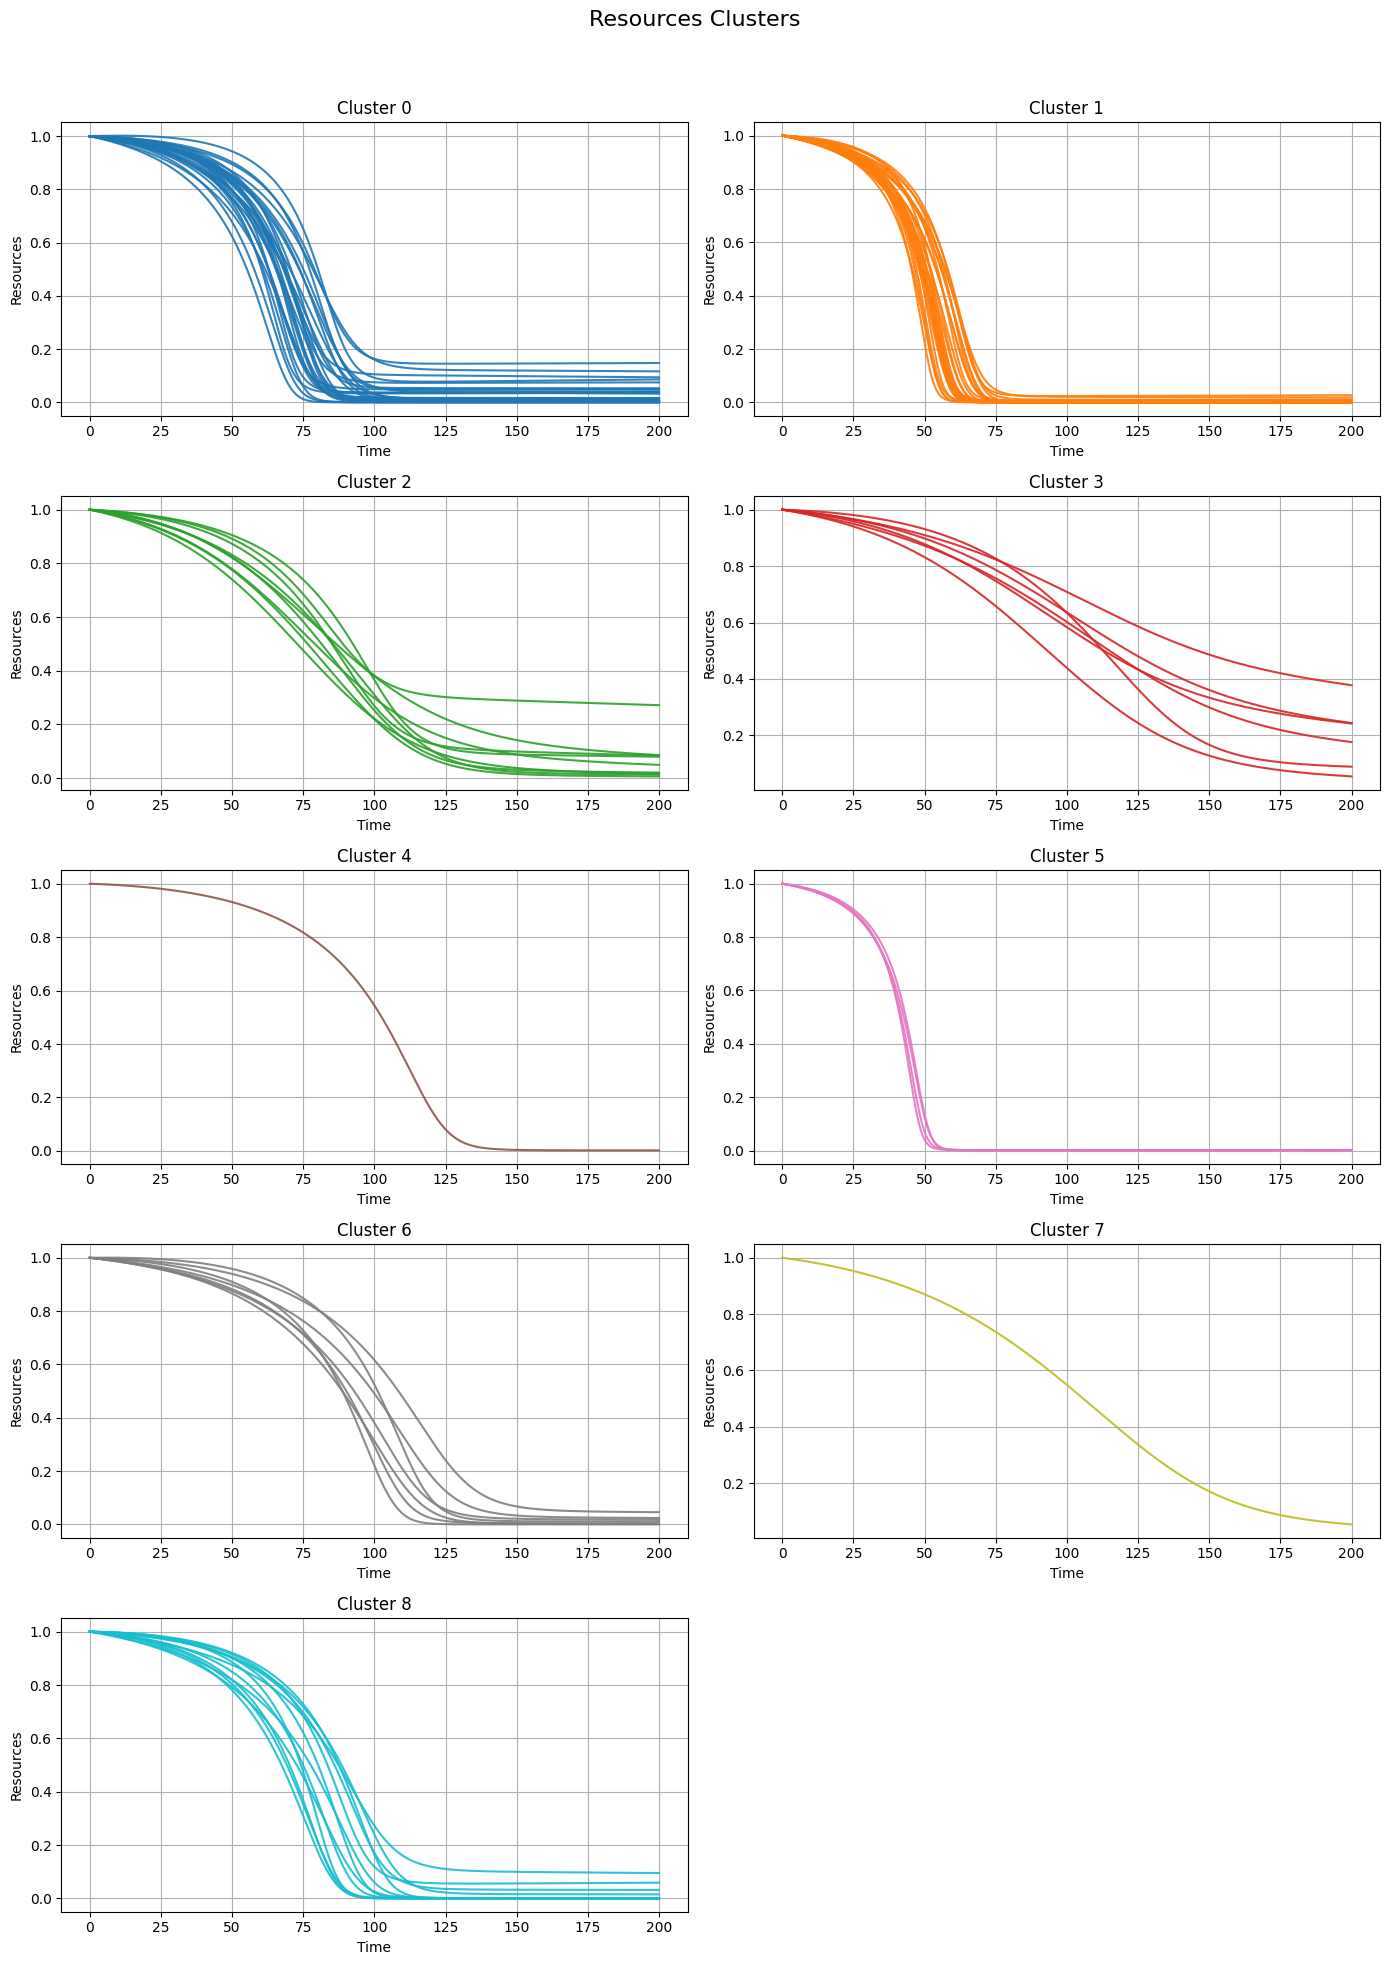

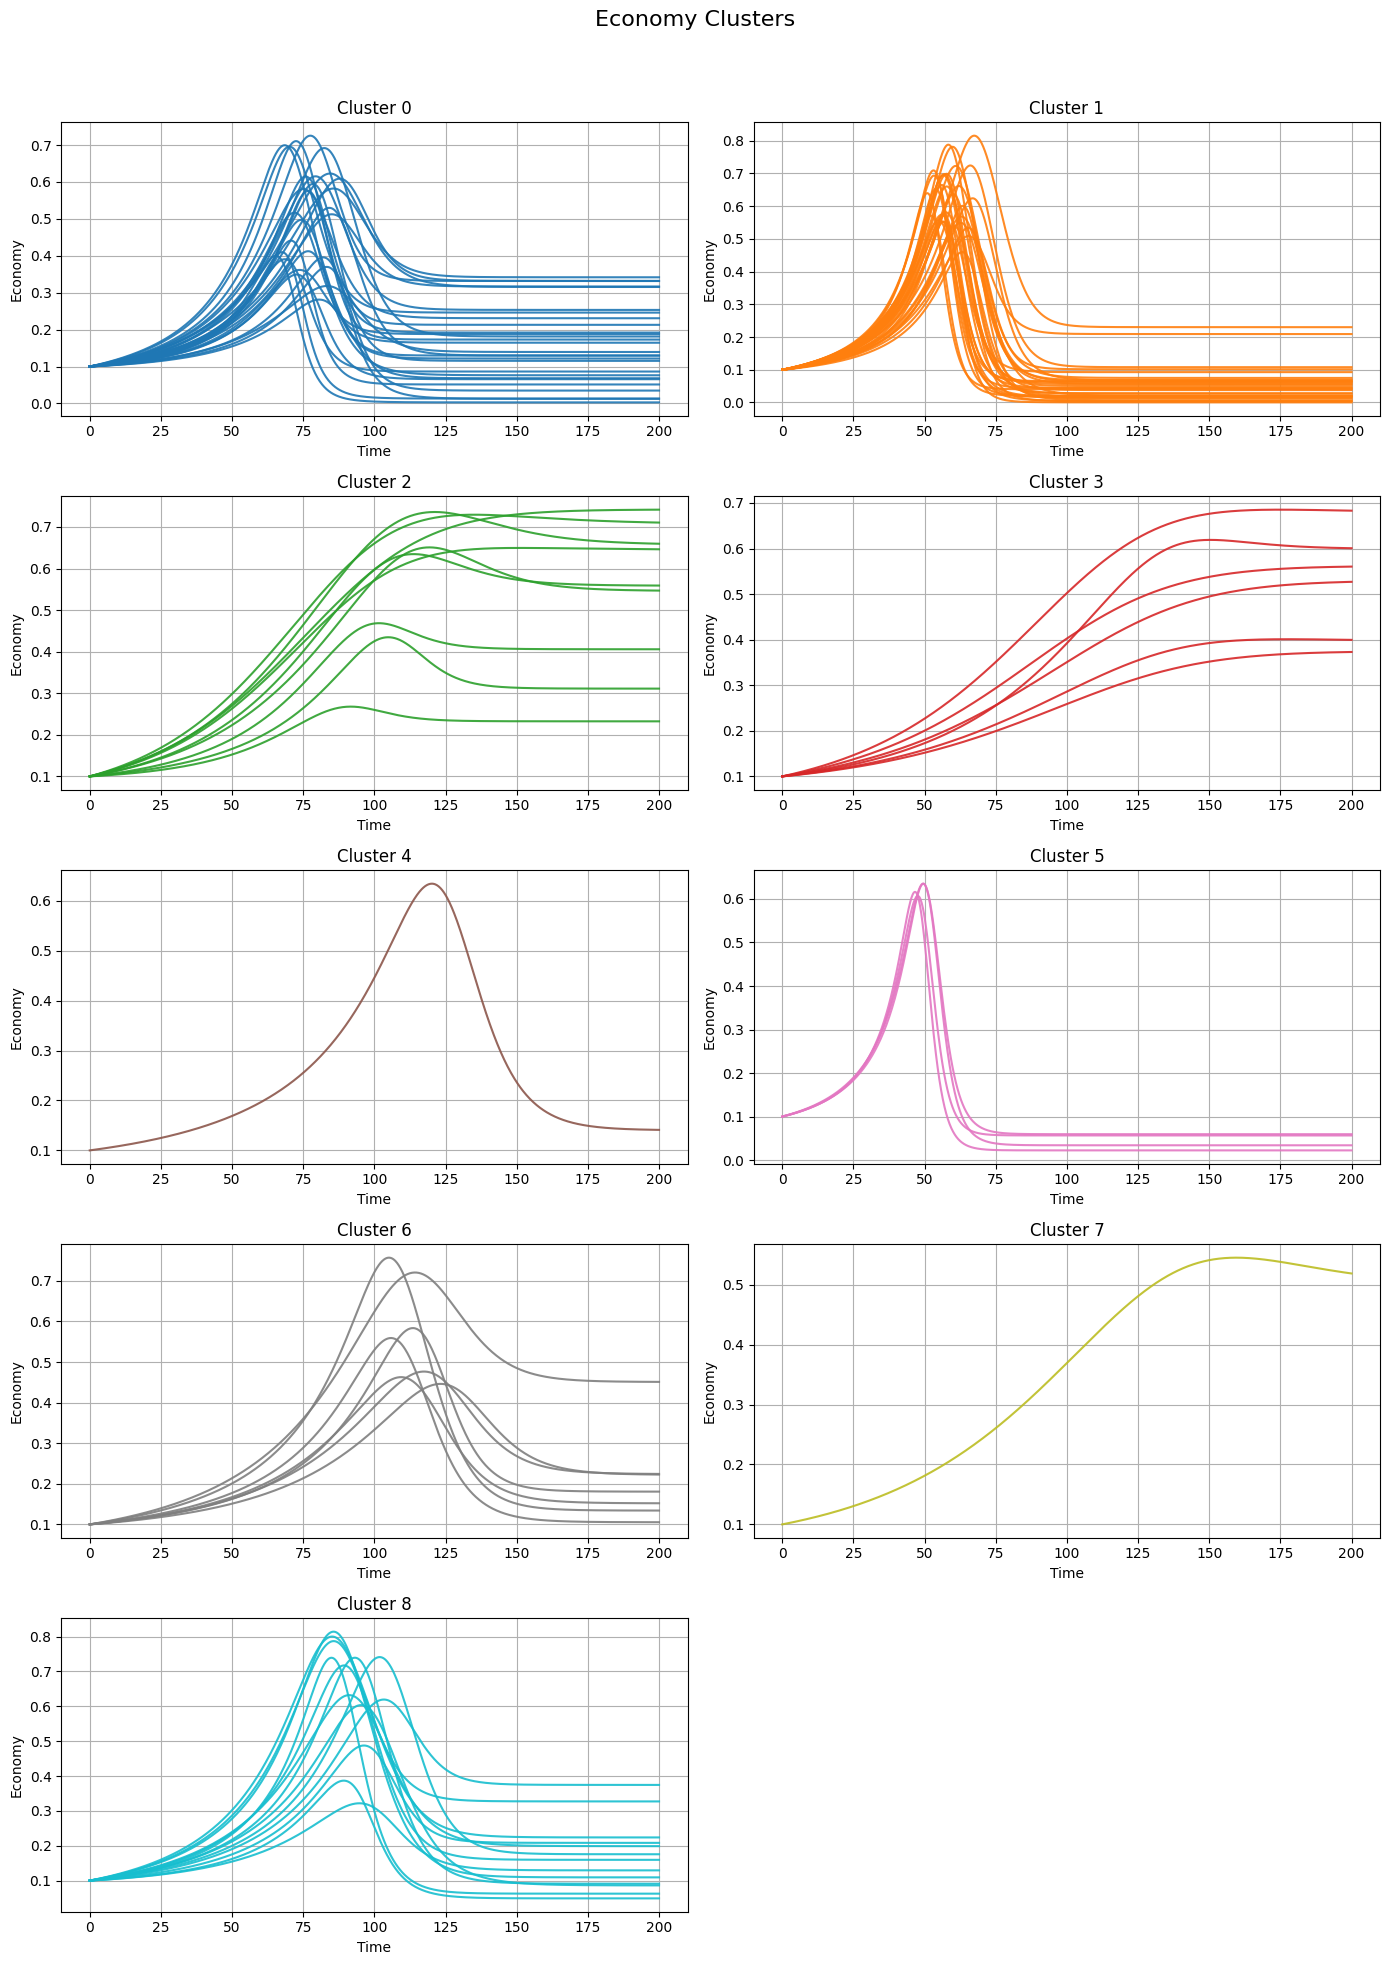

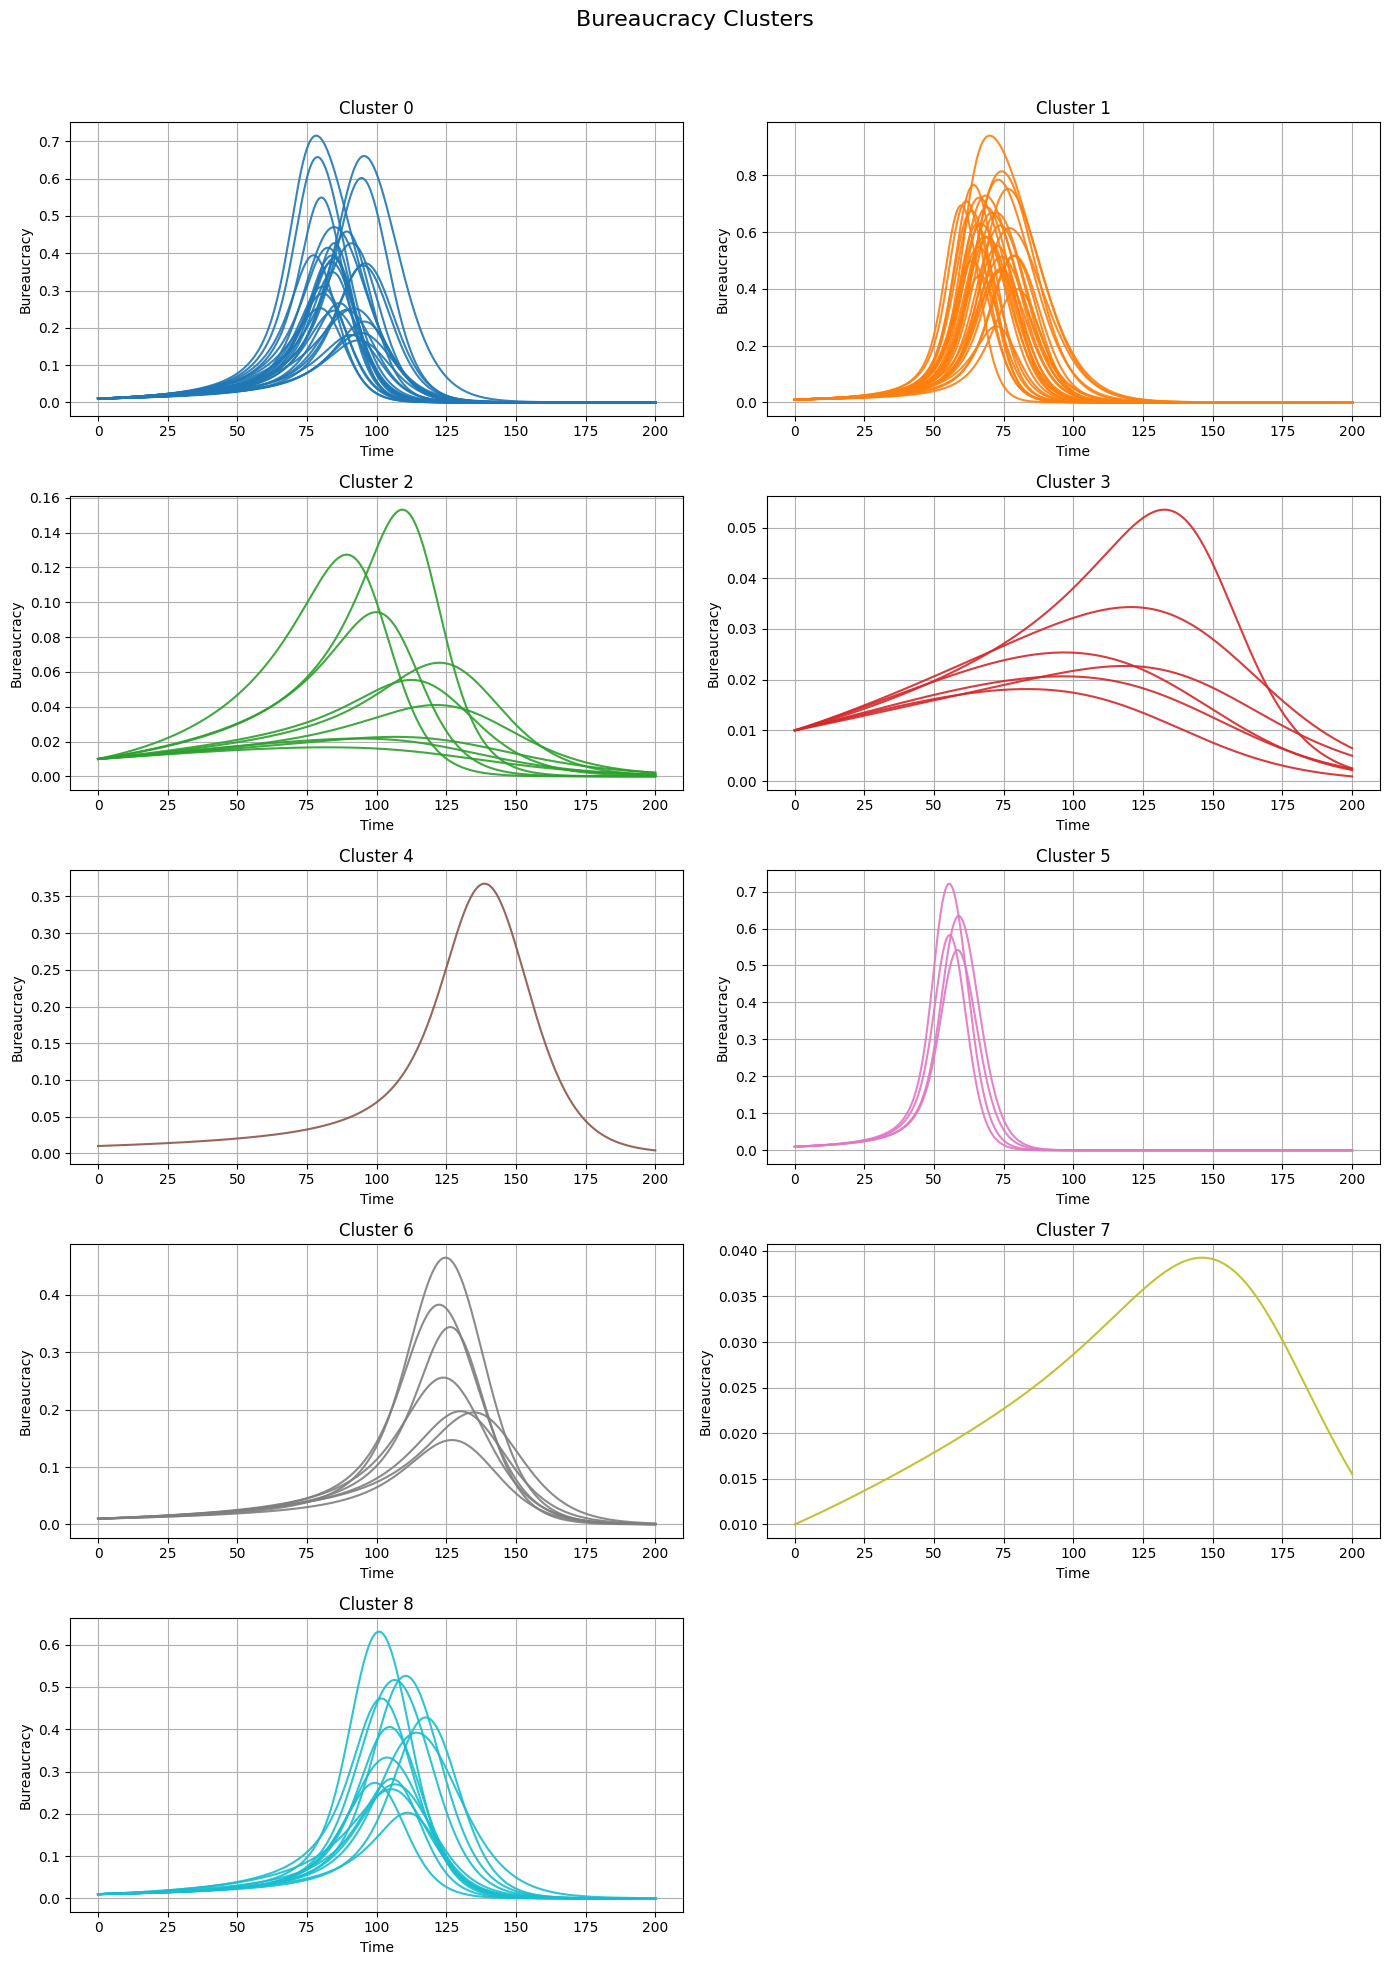

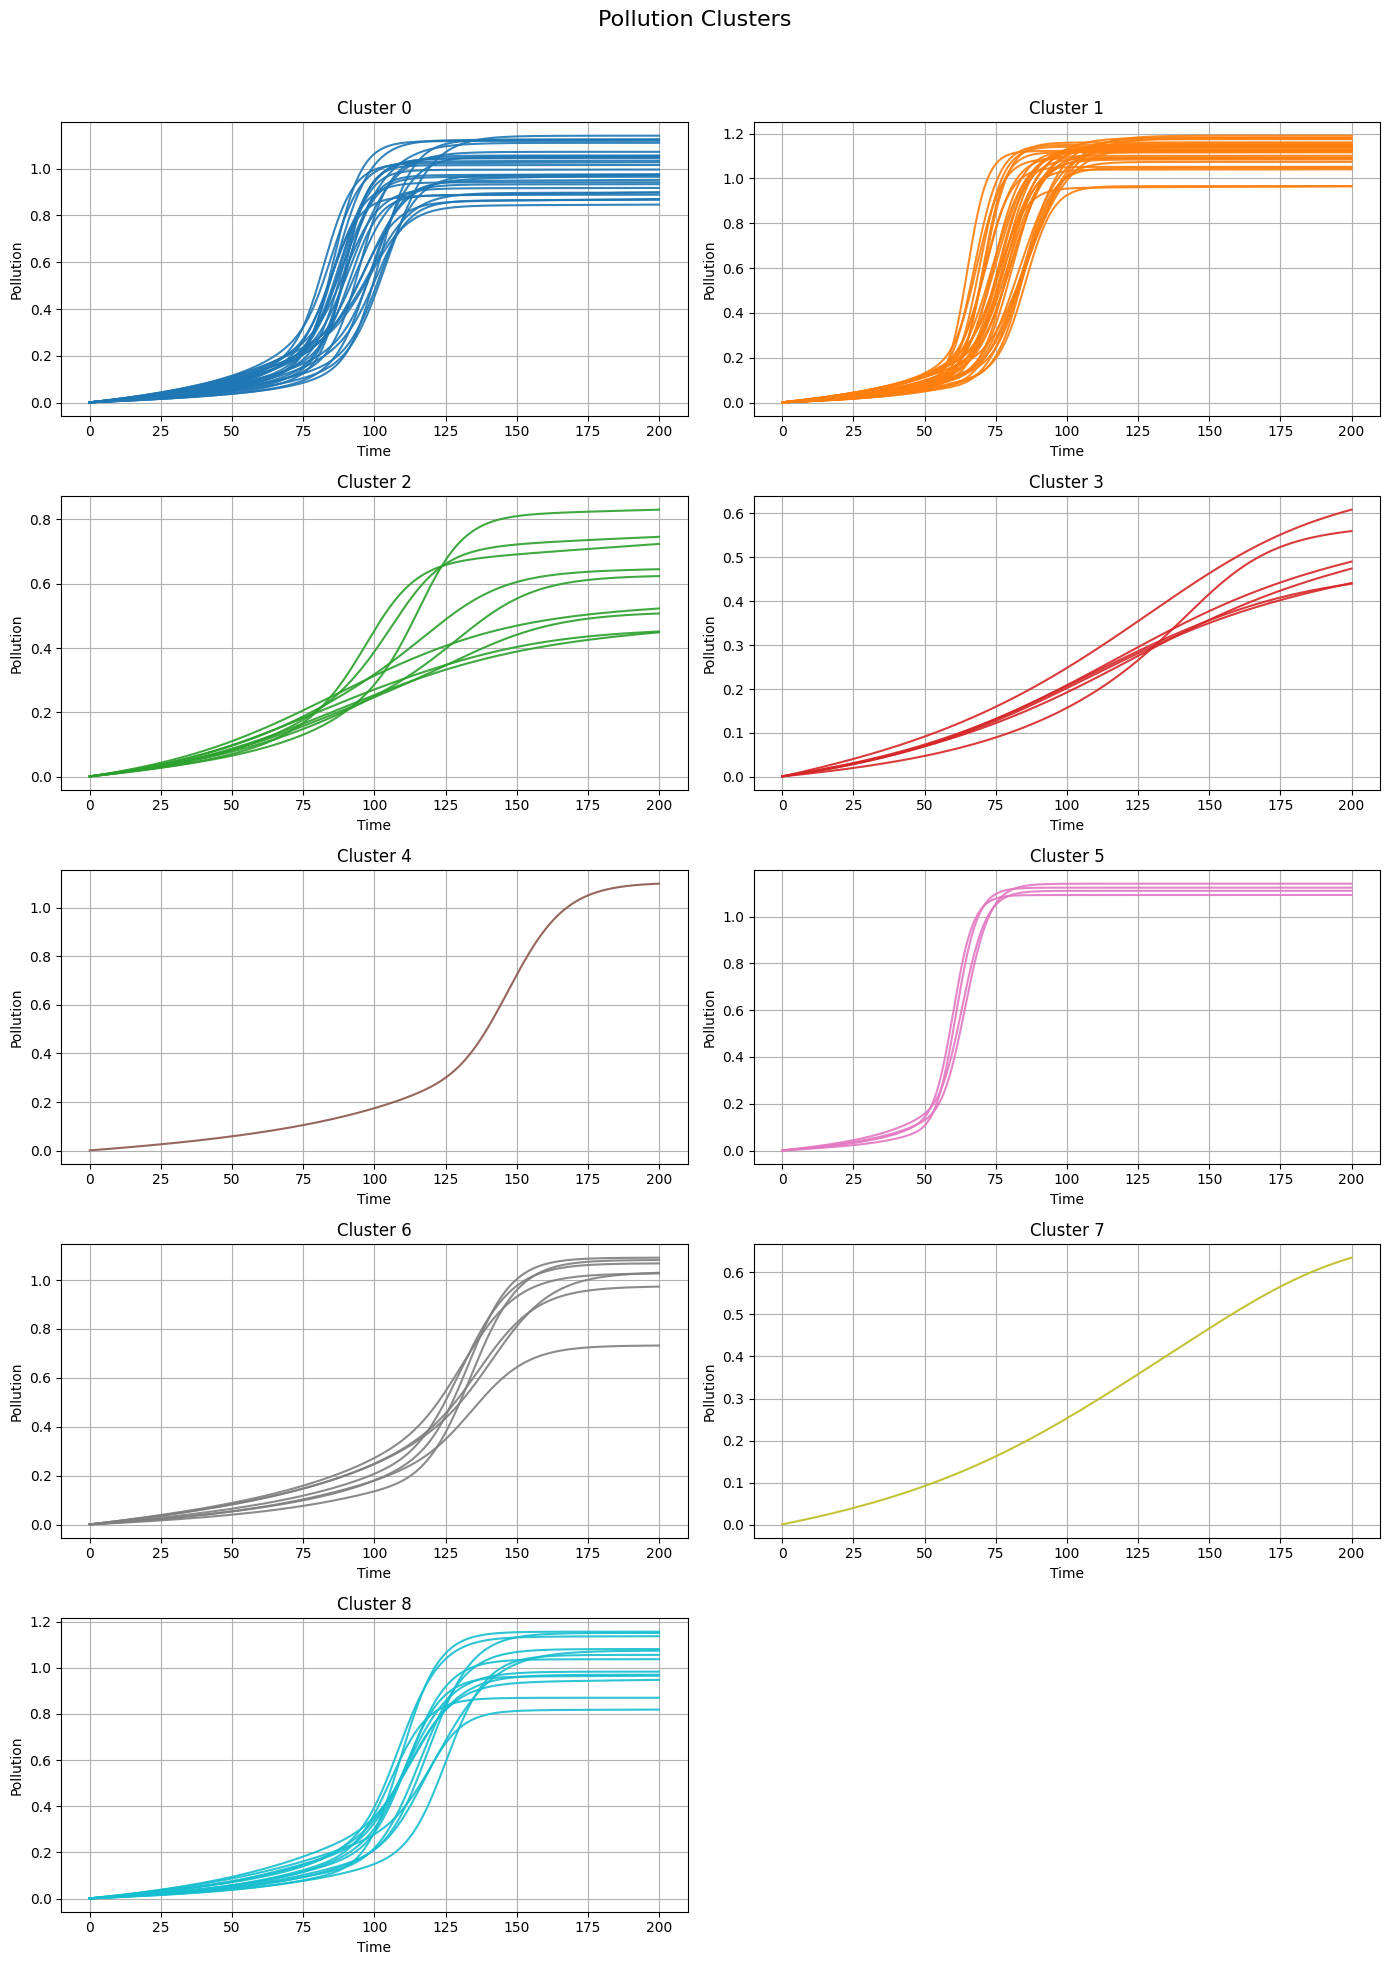

In [338]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

In [339]:
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Resources')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Economy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Bureaucracy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Pollution')

In [340]:
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

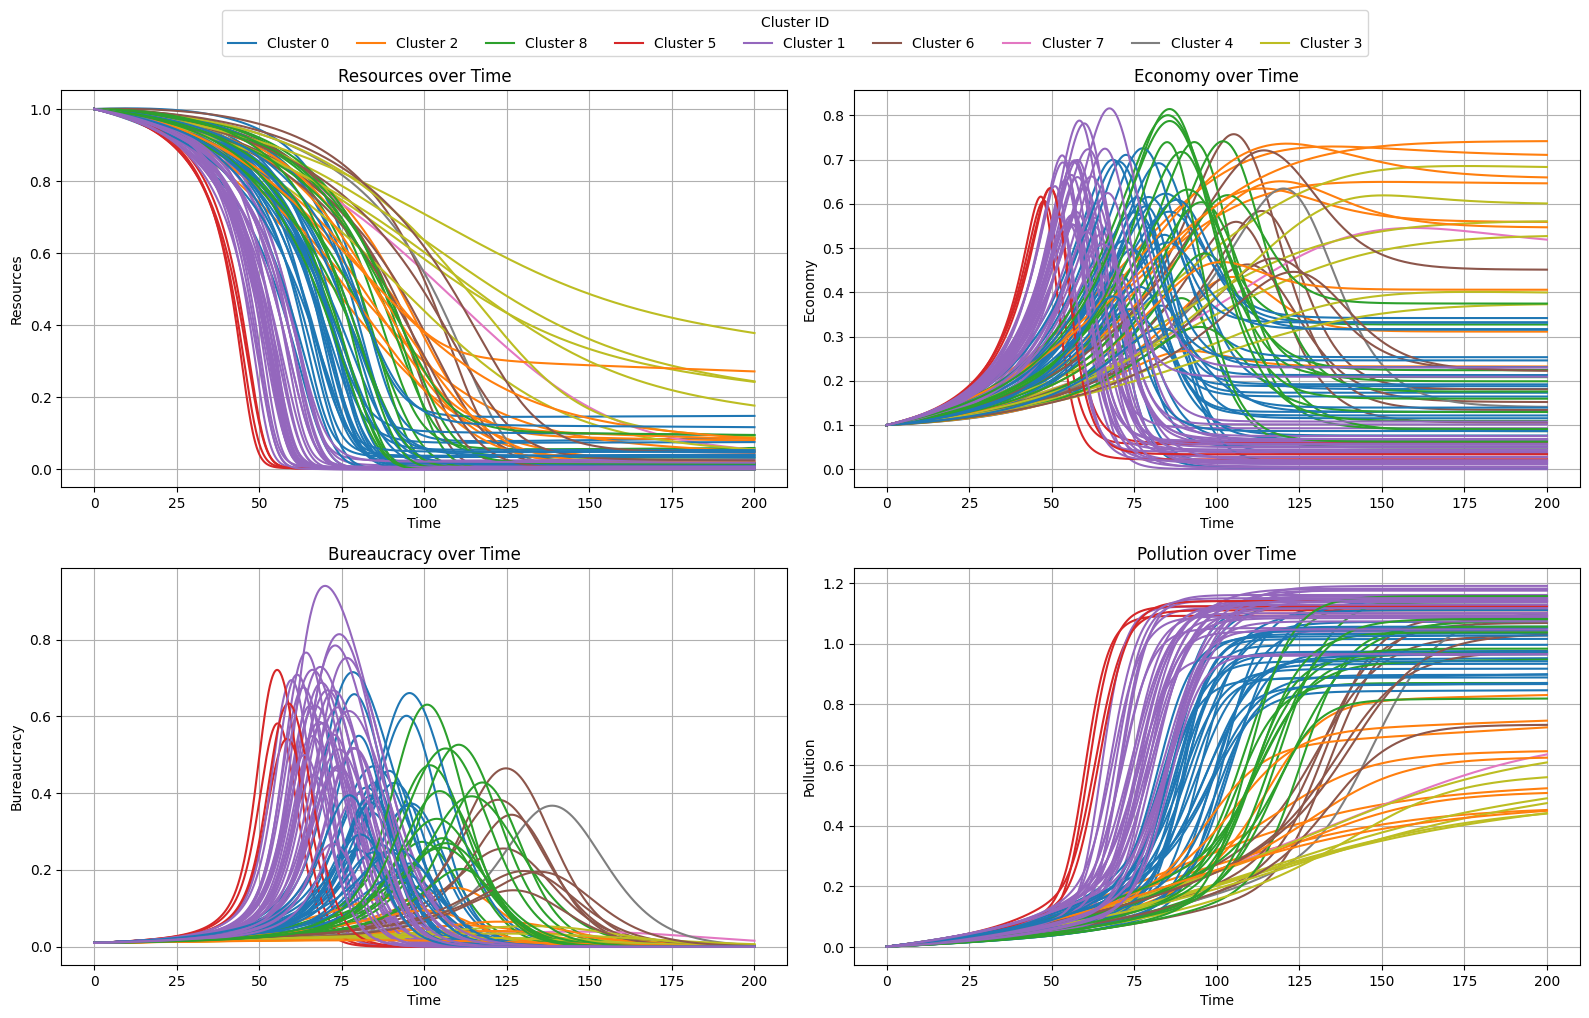

In [341]:
plot_all_variables_subplots(labeled_scenarios_df, 'kmeans_cluster_id')

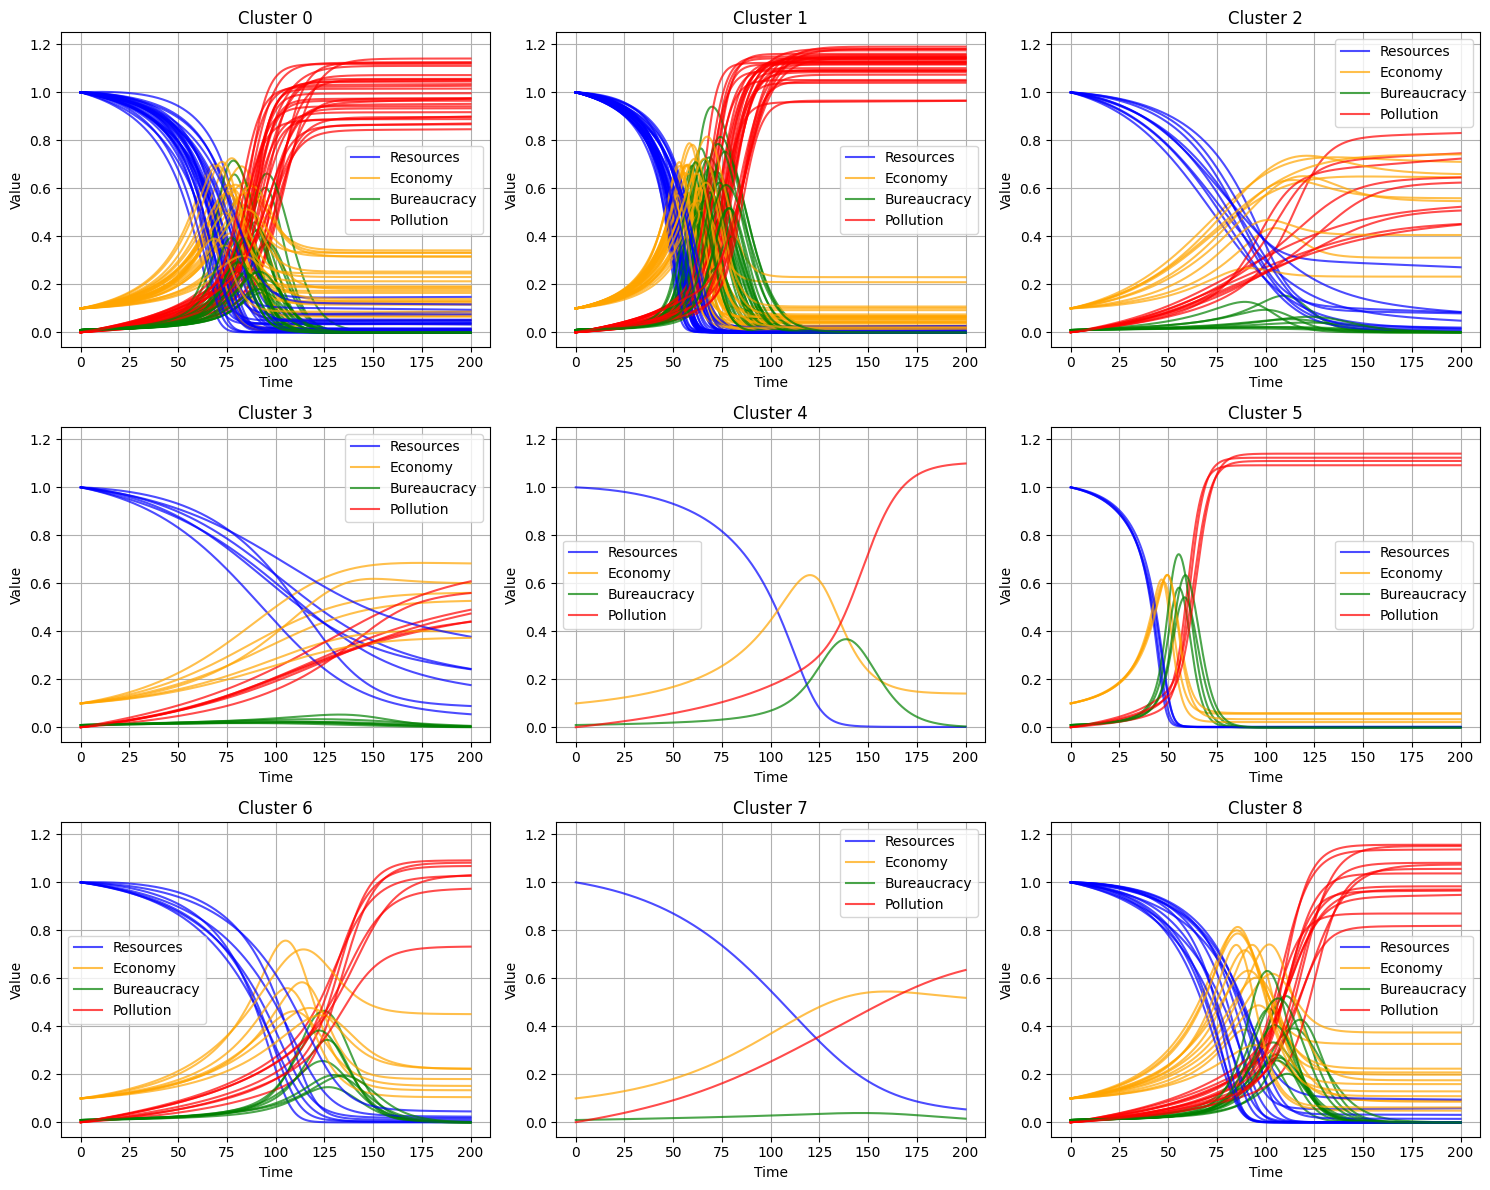

In [342]:
plot_all_clusters(labeled_scenarios_df, 'kmeans_cluster_id')